- Read HSI csv files and observation summary xls file 
- Validate whether they match well
- Calculate mean emission by platform
- Export summary to one csv file

In [1]:
import os
from glob import glob
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size - 3
# rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size 
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
df = pd.read_excel('../data/landfills_hyper_obs.xlsx')
# remove space at end
df['name'] = df['name'].str.strip()

In [4]:
data_dir = '../data/Hyper_TROPOMI_plume/'

filelist = list(chain(*[glob(os.path.join(data_dir, '**', '*csv'), recursive=True)]))

df_hyper = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)
df_hyper['emission_uncertainty(%)'] = df_hyper['emission_uncertainty']/df_hyper['emission']*100
# convert units from kg/h to t/h
df_hyper['emission'] = df_hyper['emission']/1e3

df_emiss = df_hyper.groupby(['country', 'name', 'platform'], as_index=False)\
    .agg({'plume_longitude':'mean', 'plume_latitude':'mean', 'emission':'mean',
          'emission_uncertainty(%)': 'mean', 'plume_id': 'count'})\
    .rename(columns={'plume_id': 'plume_count'})

# remove space at end
df_emiss['name'] = df_emiss['name'].str.strip()

## Validate csv and excel files

In [5]:
def validate_name(df_emiss, df):
    csv_name = df_emiss['name'].drop_duplicates()
    excel_name = df['name'].drop_duplicates()
    name_valid = csv_name.isin(excel_name)
    if all(name_valid):
        print('All csv landfill names are in the excel file')
    else:
        print(csv_name[~name_valid], 'is not in the excel file')

def append_excel_data(row, df):
    count = df[df['name']==row['name']][f"plume({row['platform'].lower()})"].item()
    overpass = df[df['name']==row['name']][f"overpass({row['platform'].lower()})"].item()

    return int(count), int(overpass)

In [6]:
validate_name(df_emiss, df)

All csv landfill names are in the excel file


In [7]:
df_emiss['count'], df_emiss['overpass'] = zip(*df_emiss.apply(append_excel_data, args=(df,), axis=1))

# this should be empty
df_emiss.query('plume_count != count')

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass


## Ratio of plume and overpass

In [8]:
df_emiss['ratio'] = df_emiss['plume_count']/df_emiss['overpass']

## Check CDF and source persistence

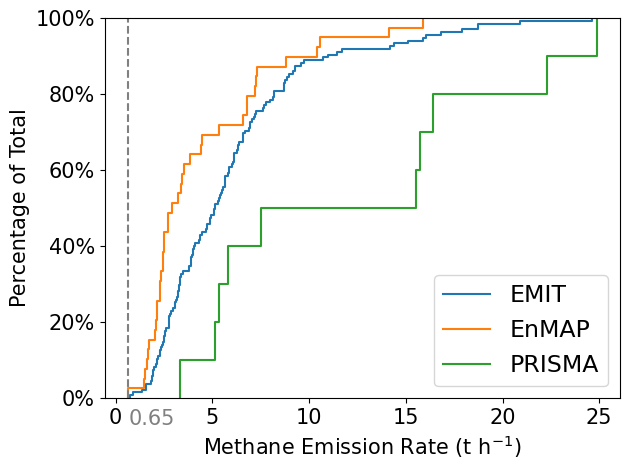

In [9]:
fig, axs = plt.subplots()

axs.ecdf(df_hyper[df_hyper['platform']=='EMIT']['emission'], label='EMIT')
axs.ecdf(df_hyper[df_hyper['platform']=='EnMAP']['emission'], label='EnMAP')
axs.ecdf(df_hyper[df_hyper['platform']=='PRISMA']['emission'], label='PRISMA')

axs.set_xlabel('Methane Emission Rate (t h$^{-1}$)')
axs.set_ylabel('Percentage of Total')
axs.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.axvline(x=df_hyper['emission'].min(), color='gray', linestyle='--')
plt.text(df_hyper['emission'].min(), -0.07, np.round(df_hyper['emission'].min(), 2), c='gray', size=font_size-2)

plt.legend()
fig.tight_layout()
fig.savefig('../figures/emission_cdf.pdf')

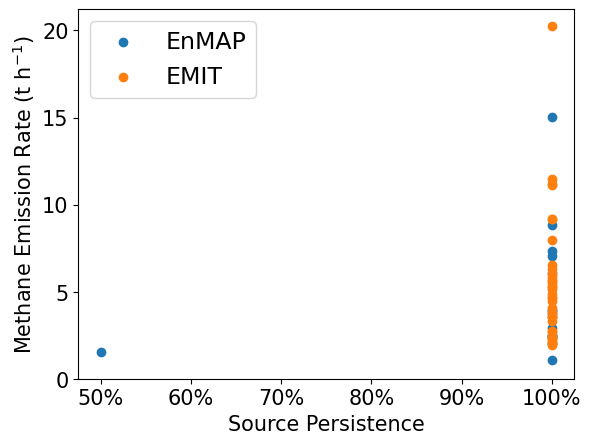

In [10]:
fig, axs = plt.subplots()
plt.scatter(df_emiss[df_emiss['platform']=='EnMAP']['ratio'], df_emiss[df_emiss['platform']=='EnMAP']['emission'], label='EnMAP')
plt.scatter(df_emiss[df_emiss['platform']=='EMIT']['ratio'], df_emiss[df_emiss['platform']=='EMIT']['emission'], label='EMIT')
plt.xlabel('Source Persistence')
axs.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylabel('Methane Emission Rate (t h$^{-1}$)')
plt.ylim(ymin=0)

plt.legend()

## Calculate mean emission and uncertainty

In [11]:
# assume 0 emission for no plume
df_emiss['emission_mean'] = df_emiss['emission']*df_emiss['plume_count']/df_emiss['overpass']
df_emiss['emission_ratio'] = df_emiss['emission_mean']/df_emiss['emission']

Text(0.5, 0, 'Landfills')

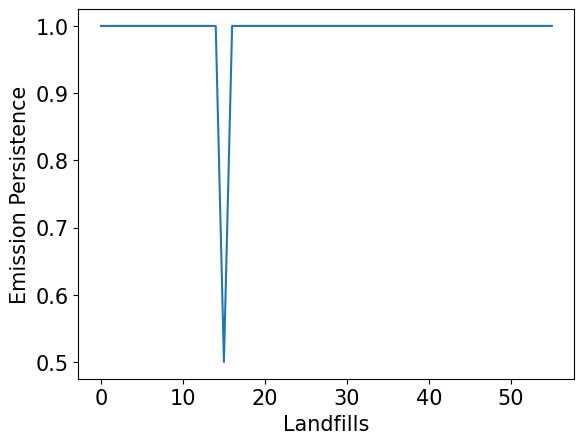

In [12]:
# df_emiss[df_emiss['platform'].isin(['EnMAP', 'EMIT'])].sort_values('emission_ratio')[['country', 'name', 'emission', 'emission_mean','emission_ratio', 'plume_count', 'overpass']]
df_emiss[df_emiss['platform'].isin(['EnMAP', 'EMIT'])]['emission_ratio'].plot()
plt.ylabel('Emission Persistence')
plt.xlabel('Landfills')

## Merge into one csv file

In [13]:
df_summary = df_emiss[['country', 'name', 'platform', 'plume_latitude', 'plume_longitude',
          'emission_mean', 'emission_uncertainty(%)', 'plume_count', 'overpass']]\
            .rename(columns={'plume_latitude': 'latitude', 'plume_longitude': 'longitude', 'emission_mean': 'emission'})
df_summary = df_summary.merge(df[['name', 'emissions_quantity', 'emissions_factor', 'capacity', 'activity', 'metadata_source', 'metadata_report_year']], on='name', how='left')

In [14]:
df_summary

,country,name,platform,latitude,longitude,emission,emission_uncertainty(%),plume_count,overpass,emissions_quantity,emissions_factor,capacity,activity,metadata_source,metadata_report_year
0,Argentina,González Catán,EMIT,-34.785059,-58.665998,2.667422,47.745338,3,3,19079.02,0.041004,1200000.00,465297.85,Waste Atlas,2013.0
1,Argentina,González Catán,EnMAP,-34.786969,-58.667128,2.078801,36.098055,2,2,19079.02,0.041004,1200000.00,465297.85,Waste Atlas,2013.0
2,Argentina,Norte III,EMIT,-34.530310,-58.619856,20.267290,38.008654,4,4,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
3,Argentina,Norte III,EnMAP,-34.529089,-58.621926,15.021481,31.581689,2,2,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
4,Argentina,Norte III,PRISMA,-34.526783,-58.627277,23.574449,36.212945,2,2,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
5,Argentina,Piedra Blanca,EMIT,-31.518877,-64.235094,3.557147,37.402921,2,2,14902.44,0.041850,NaN,356094.72,METER/OSM,2022.0
6,Bangladesh,Aminbazar,EMIT,23.798009,90.299357,3.776973,55.540671,1,1,13506.95,0.046725,NaN,289072.51,METER/OSM,2022.0
7,Brazil,Pedreira,EMIT,-23.403868,-46.560920,9.146339,37.616219,1,1,NaN,NaN,NaN,NaN,NaN,NaN
8,Brazil,São Paulo,EMIT,-23.351949,-46.776142,11.454447,37.576156,1,1,NaN,NaN,NaN,NaN,NaN,NaN
9,China,Ürümqi,EMIT,44.039022,87.865791,9.144791,46.245832,5,5,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_summary.to_csv('../data/landfills_hyper_summary.csv', index=False)